# Updating code that uses `seaborn.distplot`

[Michael Waskom](http://mwaskom.github.io/) | May 14, 2022

Seaborn's [`distplot`](https://seaborn.pydata.org/generated/seaborn.distplot.html) function was deprecated in v0.11.0, a release that included several new functions for plotting data distributions. Calling `distplot` on v0.11.0 or later issues a warning urging the user to update their code with one of two new functions: either [`displot`](https://seaborn.pydata.org/generated/seaborn.displot.html) (note, no `t`) or [`histplot`](https://seaborn.pydata.org/generated/seaborn.histplot.html).

While the two new functions encompass all of the functionality present in `distplot` — and much more — they have differnet signatures and are not drop-in replacements. This notebook provides a guide to updating. But first, some questions.

#### Why is `distplot` deprecated? I use it all the time.

As one of the very first functions added to seaborn (well before it was developed with the expectation that otheres would use it), the `distplot` API is quite distinct from nearly all of the functions added in later releases. There is no way to reference a column of a dataframe, it does not support conditional `hue` mapping, and it does not have `x`/`y` parameters or use them to orient the distribution.

While it is similar in spirit to ["figure-level"](https://seaborn.pydata.org/tutorial/function_overview.html) functions like `catplot` or `relplot`— becasue it can plot multiple kinds of distributions through one interface — `distplot` does so with a set of boolean switches rather than a `kind` parameter. And it is not integrated with a `FacetGrid`, so it cannot produce subplots.

Therefore, when it came time to update the distributions module in v0.11.0, there was no clean way to deprecate old usage patterns and modernize the API. Deprecation / replacement was the best solution. This allowed the new functions to share a consistent API with the rest of seaborn and to be *much* more powerful.

#### Why replace it with a nearly identically named functions?

Yeah, this is obviously not ideal. It was totally foreseeable that people would get tripped up by `distplot`/`displot`, and I apologize for that (except to the person who sent me a long, very rude email about it). I put a lot of effort into thinking of a better name, but ultimately came up empty.

It does fit the precedent established by `catplot` and `relplot`. And, from an [etymological perspective](https://en.wiktionary.org/wiki/distribute), it's actually the right way to split variations on "distribute", for whatever that's worth.

-----

### Guide to updating

Here's how you can go about updating your code to use the new functions. It focuses on reproducing default plots, or plots with minimal customization. The options for customization also differ, but they are amply documented in the API examples.

In [1]:
import seaborn as sns
sns.set_theme()
df = sns.load_dataset("penguins")

### `distplot` vs `histplot` vs `displot`

In its most basic invocation, `distplot` shows both a histogram (using density normalization) and a superimposed kernel density estimate:

/Users/mwaskom/code/seaborn/seaborn/distributions.py:2532: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='flipper_length_mm', ylabel='Density'>

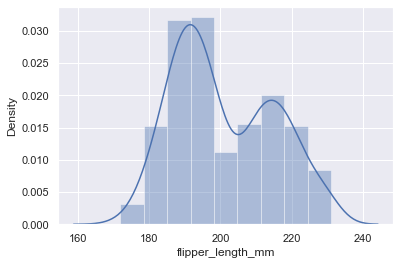

In [2]:
sns.distplot(df["flipper_length_mm"])

In contrast, `histplot` shows a more standard count histogram.

<AxesSubplot:xlabel='flipper_length_mm', ylabel='Count'>

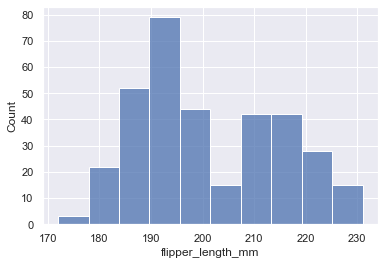

In [3]:
sns.histplot(df["flipper_length_mm"])

The default for `displot` is the same (as it's basically using `histplot` under the hood), although it uses and returns a `FacetGrid` rather than an `Axes` because it is a [figure-level function](https://seaborn.pydata.org/tutorial/function_overview.html#figure-level-vs-axes-level-functions):

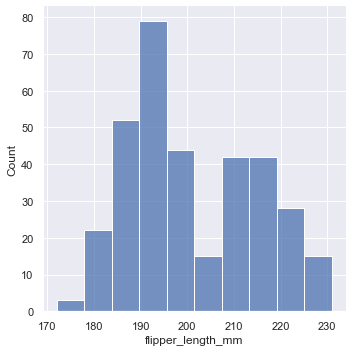

In [4]:
sns.displot(df["flipper_length_mm"])

### Replicating basic `distplot` output

Both new functions support the kernel density estimate line, by passing `kde=True`:

<AxesSubplot:xlabel='flipper_length_mm', ylabel='Count'>

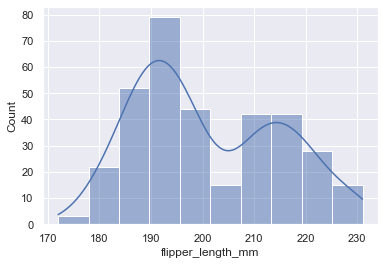

In [5]:
sns.histplot(df["flipper_length_mm"], kde=True)

This gets us pretty close to the `distplot` output, although the y axis is still showing counts. That was a frequently requested feature and many people may prefer it, but to more closely replicate `distplot` we can set `stat="density"`:

<AxesSubplot:xlabel='flipper_length_mm', ylabel='Density'>

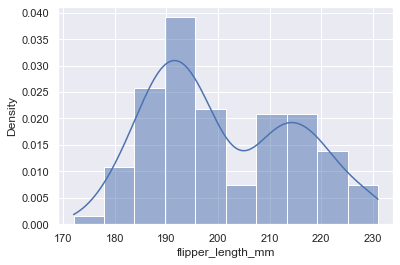

In [6]:
sns.histplot(df["flipper_length_mm"], kde=True, stat="density")

Notice how the `KDE` curve spills out past the histogram in `distplot`, but only covers the actual range of the data in `histplot`. This behavior can be controlled with the `cut` parameter, which you'd need to pass through using `kde_kws`. The `histplot` default is 0, while the `distplot` default is 3 (the units are multiples of the kernel bandwidth):

<AxesSubplot:xlabel='flipper_length_mm', ylabel='Density'>

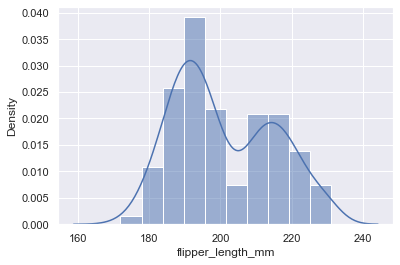

In [7]:
sns.histplot(
    df["flipper_length_mm"], kde=True,
    stat="density", kde_kws=dict(cut=3)
)

The only other missing piece is that the default opacity of the `distplot` histogram is a little lower:

<AxesSubplot:xlabel='flipper_length_mm', ylabel='Density'>

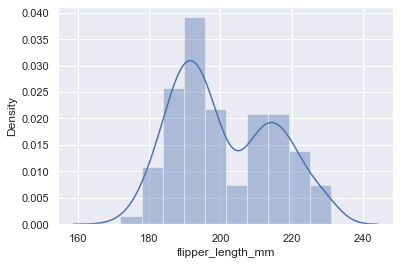

In [8]:
sns.histplot(
    df["flipper_length_mm"], kde=True,
    stat="density", kde_kws=dict(cut=3),
    alpha=.4, edgecolor=(1, 1, 1, .4),
)

One other twist to be aware of involves the default bin size. By default, `distplot` uses the [Freedman-Diaconis](https://en.wikipedia.org/wiki/Freedman%E2%80%93Diaconis_rule) rule but shows no more than 50 bars. In contrast, `histplot` entirely delegates its bin selection to numpy's `"auto"` default, which can use different reference rules depending on data characteristics and can choose very narrow bar widths with large datasets. You may need to specify that upper-limit (`bins=50`) to exactly reproduce previous plots.

### Showing a density curve

While `histplot` (and `displot`) can layer a kernel density curve on top of the histogram, `distplot` can also show _only_ the density curve if the histogram is disabled:

/Users/mwaskom/code/seaborn/seaborn/distributions.py:2532: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='flipper_length_mm', ylabel='Density'>

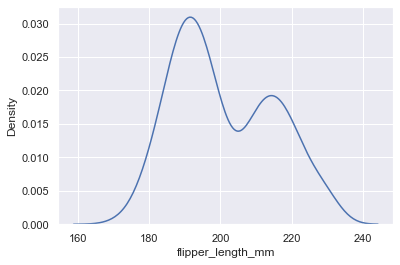

In [9]:
sns.distplot(df["flipper_length_mm"], hist=False)

In contrast, the modern approach would call [`kdeplot`](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) directly for an axes-level plot:

<AxesSubplot:xlabel='flipper_length_mm', ylabel='Density'>

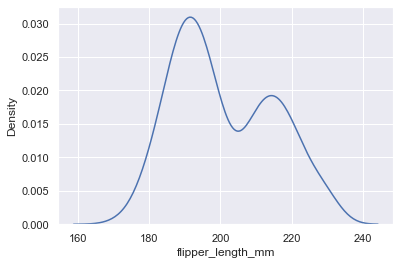

In [10]:
sns.kdeplot(df["flipper_length_mm"])

Or use `kind="kde"` in `displot`:

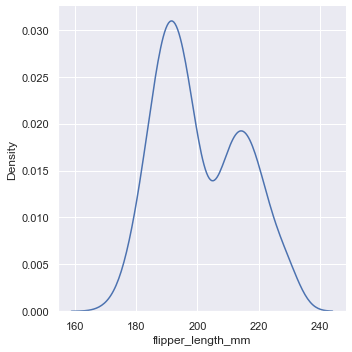

In [11]:
sns.displot(df["flipper_length_mm"], kind="kde")

### Adding a rug

One way that `distplot` and `histplot` differ is that the latter has no built-in rug plot. You would need to call `rugplot` directly:

<AxesSubplot:xlabel='flipper_length_mm', ylabel='Count'>

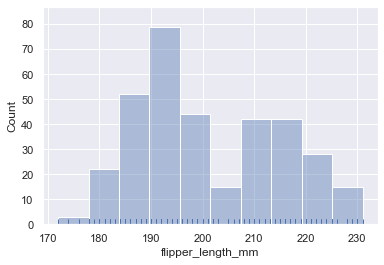

In [12]:
sns.histplot(df, x="flipper_length_mm", alpha=.4)
sns.rugplot(df, x="flipper_length_mm")

But it's always possible to add a rug in `displot`:

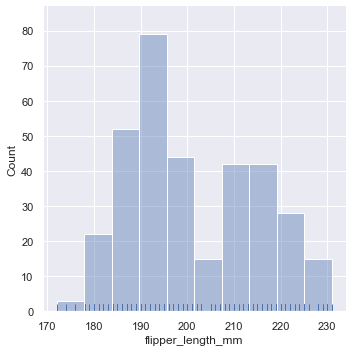

In [13]:
sns.displot(df, x="flipper_length_mm", alpha=.4, rug=True)

### Further explorations

While it can be a pain to update code or change one's habits, I hope that the many *new* capabilities brought by `histplot` and `displot` feel worth the effort in the long run. I encourage you to read through their docs and take advantage of that power.